## Interview Task

To complete this assignment you will need the publicly available dataset of the NYC taxi rides, focusing on the yellow taxi trip records for September 2018, which you can download in https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page .

1. Perform an EDA of the downloaded dataset, highlighting the 5 most interesting metrics/results of the exploration.
2. If each taxi driver could only be assigned to one pickup (PU) location, which one would you recommend?
3. Design a system to detect fraud in taxi rides. Are there any suspicious rides in the dataset?
4. Implement a model to predict the fare based on the fare characteristics and ship it in such a way that it can be applied and tested against another monthly dataset.

Please complete the tasks, preferably in Python, providing runnable code and as much explanation as needed. It is expected it will take around 5-6 hours to complete them, but note that some of the tasks are quite open ended, so feel free to be as creative as you want.

In [ ]:
!pip install autoviz

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/yellow_tripdata_2018-09.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040133 entries, 0 to 8040132
Data columns (total 17 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   RatecodeID             int64  
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
dtypes: float64(8), int64(6), object(3)
memory usage: 1.0+ GB


In [ ]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-09-01 00:01:35,2018-09-01 00:09:48,2,1.5,1,N,161,107,1,7.5,0.5,0.5,0.00,0.0,0.3,8.80
1,1,2018-09-01 00:22:22,2018-09-01 00:28:55,1,1.0,1,N,233,100,1,6.5,0.5,0.5,2.00,0.0,0.3,9.80
2,1,2018-09-01 00:38:10,2018-09-01 00:44:42,1,1.0,1,N,164,163,2,6.5,0.5,0.5,0.00,0.0,0.3,7.80
3,1,2018-09-01 00:46:36,2018-09-01 00:54:49,1,1.9,1,N,48,140,1,8.5,0.5,0.5,1.00,0.0,0.3,10.80
4,1,2018-09-01 00:59:46,2018-09-01 01:02:41,1,0.6,1,N,262,263,1,4.5,0.5,0.5,1.15,0.0,0.3,6.95


First look at the data (additionally, what info we can gather from the data dictionary that can be downloaded):

*   We can see very important characteristic of a taxi trip such as:

>> a.) Trip distance (float, measured in miles)

>> b.) Passanger count (int)

>> c.) Pick up and drop off location (as ID)

>> d.) Payment type (categorical, flag var)
>>>> **1** = *Credit card*
>>>> **2** = *Cash*
>>>> **3** = *No charge*
>>>> **4** = *Dispute*
>>>> **5** = *Unknown*
>>>> **6** = *Voided trip*

>> e.) store_and_fwd_flag: was the trip record held in vehicle memory before sending it to the vendor or not (binary, flag var)
>>>> **Y** means "store and forward trip"
>>>> **N** means not a store and forward trip

>> f.) Rate Code ID (categorical, flag var)
>>>> **1** = Standard rate
>>>> **2** = JFK
>>>> **3** = Newark
>>>> **4** = Nassau or Westchester
>>>> **5** = Negotiated fare
>>>> **6** = Group ride

>> g.) All types of prices: 
>>>> **fare amount** : time-and-distance fare calculated by the meter.

>>>> **extra**: Miscellaneous extras and surcharges. Currently, this only includes the $0.50 and $1 rush hour and overnight charges.

>>>> **mta tax**: $0.50 MTA tax that is automatically triggered based on the metered rate in use.

>>>> **tip_amount**: Tip amount, which is automatically populated for credit card tips. Cash tips are **not included**.

>>>> **tolls_amount**: Total amount of all tolls paid in trip.

>>>> **improvement surcharge**: $0.30 improvement surcharge assessed trips at the flag drop

>>>> **total amount**: The total amount charged to passengers. Does not include cash tips.

>> h.) Vendor ID (categorical, flag) which code indicates the TPEP provider

>>>> **1** = Creative Mobile Technologies, LLC
>>>> **2** = VeriFone Inc.


Additional features to include:
*    We can easily calculate the **duration of the trip** from the simple subtraction of pickup time from the dropoff time






Let's see if there are any missing values

In [ ]:
df.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

Right away we can see that there are no missing values in this data set. This is very good.

### Task 0: Data Clean-up and Feature Engineering

Converting pick up and drop off times to datetime

In [ ]:
df["tpep_pickup_datetime"] = pd.to_datetime(df.tpep_pickup_datetime)
df["tpep_dropoff_datetime"] = pd.to_datetime(df.tpep_dropoff_datetime)

Calculating trip duration and measuring it in seconds, as that is the most granular time unit (for this usecase) and most precise. 

In [ ]:
df["trip_duration_seconds"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).astype('timedelta64[s]')

In [ ]:
df["trip_duration_seconds"]

0          493.0
1          393.0
2          392.0
3          493.0
4          175.0
           ...  
8040128    356.0
8040129    177.0
8040130    554.0
8040131    610.0
8040132     71.0
Name: trip_duration_seconds, Length: 8040133, dtype: float64

Other quick features that I would like to create are:


*   Flag variable for day or night: has the taxi ride
*   Categorical variable pointing to what day of the week it is



In [ ]:
df['daytime_flag'] = (df["tpep_pickup_datetime"].dt.hour > 5) & (df["tpep_pickup_datetime"].dt.hour < 18)
df['daytime_flag'] = pd.Categorical(df['daytime_flag'])

We should keep a record of the day of the week, as it might be correlated with features such as time duration or distance. 

For that, we create a new categorical feature with values 0-6: Monday=0, Sunday=6.

In [ ]:
df["pickup_weekday"] = df["tpep_pickup_datetime"].dt.dayofweek
df["pickup_weekday"] = pd.Categorical(df["pickup_weekday"] )

Let's see what else do we need to clean up in the data set.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040133 entries, 0 to 8040132
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   RatecodeID             int64         
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  trip_duration_seconds  float64       
 18  daytime_flag          

I would like to convert the vendorID, payment type, store_and_fwd_flag, RatecodeID, and pickup_weekday into a categorical variable.

In [ ]:
df['VendorID'] = pd.Categorical(df.VendorID)
df['RatecodeID'] = pd.Categorical(df.RatecodeID)
df['payment_type'] = pd.Categorical(df.payment_type)

In [ ]:
# Encode categorical variables
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N':0,'Y':1})
df['store_and_fwd_flag'] = pd.Categorical(df.store_and_fwd_flag)

I decided to also treat pick up and drop off location IDs as categorical variables. My argument is that they are not numeric, and they are not non-duplicate IDs, so do not act as a primary key type of ID, but rather more like a flag variable. 

They don't measure anything, instead they link the taxi ride to a location. 

In [ ]:
df['PULocationID'] = pd.Categorical(df.PULocationID)
df['DOLocationID'] = pd.Categorical(df.DOLocationID)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8040133 entries, 0 to 8040132
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               category      
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   RatecodeID             category      
 6   store_and_fwd_flag     category      
 7   PULocationID           category      
 8   DOLocationID           category      
 9   payment_type           category      
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  trip_duration_seconds  float64       
 18  daytime_flag          

In [ ]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration_seconds,daytime_flag,pickup_weekday
0,1,2018-09-01 00:01:35,2018-09-01 00:09:48,2,1.5,1,0,161,107,1,7.5,0.5,0.5,0.00,0.0,0.3,8.80,493.0,False,5
1,1,2018-09-01 00:22:22,2018-09-01 00:28:55,1,1.0,1,0,233,100,1,6.5,0.5,0.5,2.00,0.0,0.3,9.80,393.0,False,5
2,1,2018-09-01 00:38:10,2018-09-01 00:44:42,1,1.0,1,0,164,163,2,6.5,0.5,0.5,0.00,0.0,0.3,7.80,392.0,False,5
3,1,2018-09-01 00:46:36,2018-09-01 00:54:49,1,1.9,1,0,48,140,1,8.5,0.5,0.5,1.00,0.0,0.3,10.80,493.0,False,5
4,1,2018-09-01 00:59:46,2018-09-01 01:02:41,1,0.6,1,0,262,263,1,4.5,0.5,0.5,1.15,0.0,0.3,6.95,175.0,False,5


I am satisfied with how the data looks like now, so I will move forward to the EDA section.

## Task 1: EDA

Here, I plan to plot distributions of variables, find out the spread of the data through histograms and start to explore relationships between the variables

### Categorical Variables
Let's look at the categorical variables first. 

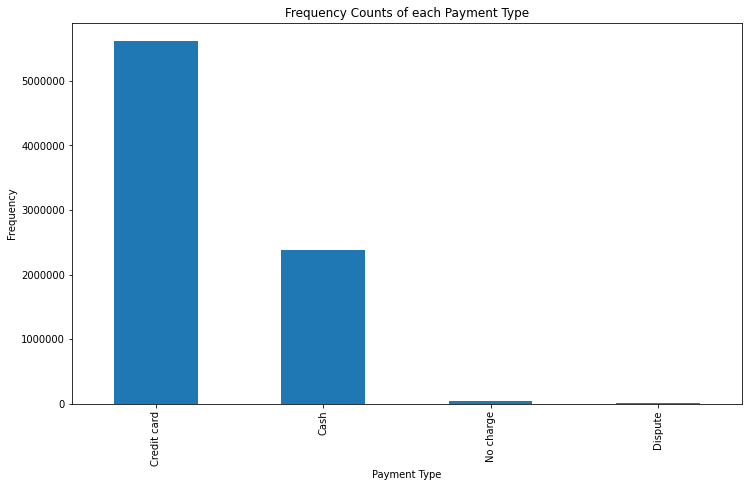

1    5614030
2    2373527
3      40456
4      12120
Name: payment_type, dtype: int64


In [ ]:
plt.ticklabel_format(style = 'plain')

ax = df['payment_type'].value_counts().rename(index={1:"Credit card", 2:"Cash", 3:"No charge", 4:"Dispute"}).plot(kind='bar',
                                    figsize=(12,7),
                                    title="Frequency Counts of each Payment Type")
ax.set_xlabel("Payment Type")
ax.set_ylabel("Frequency")

plt.show()
print(df['payment_type'].value_counts())

Interpretation: Mostly **Credit card** transactions (= 1), then there are a considerable about of **Cash** payments (= 2). There are a small number of **No charge** trips (= 3), and a very small percentage of **Disputes** (= 4)

The data contains no Unknown or Voided trips whatsoever.

You can see counts above.

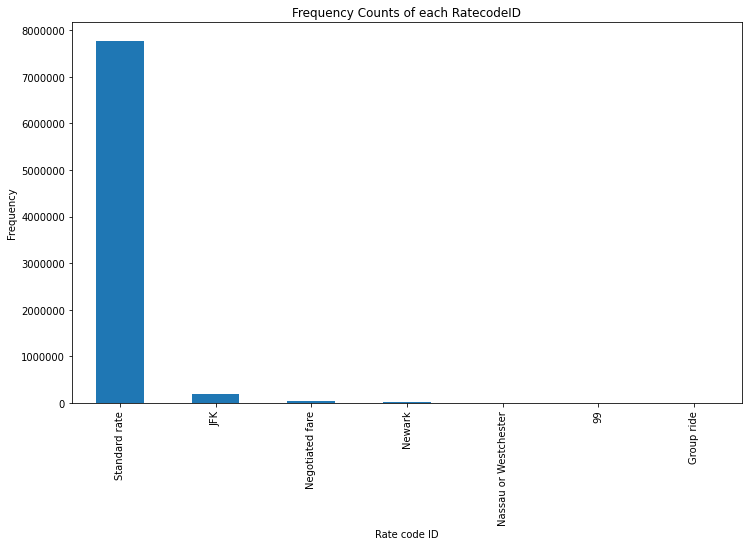

1     7779395
2      200599
5       37977
3       16630
4        5267
99        203
6          62
Name: RatecodeID, dtype: int64


In [ ]:
plt.ticklabel_format(style = 'plain')

translate = {1: "Standard rate", 2: "JFK", 3: "Newark", 4: "Nassau or Westchester", 5: "Negotiated fare", 6: "Group ride"}
ax = df['RatecodeID'].value_counts().rename(index=translate).plot(kind='bar',
                                    figsize=(12,7),
                                    title="Frequency Counts of each RatecodeID")
ax.set_xlabel("Rate code ID")
ax.set_ylabel("Frequency")
  
plt.show()
print(df['RatecodeID'].value_counts())

Rate Codes translate to: 
**1**= Standard rate,
**2**=JFK, 
**3**=Newark, 
**4**=Nassau or Westchester,
**5**=Negotiated fare,
**6**=Group ride

*Interpretation:*

So mostly **standard rate** (n = 7779395), then there are some noticable **JFK trips** (n = 200599), then some negotiated trips (n = 37977), then some **Newark trips** (n = 16630). Lastly there are some **Nassau or Westchester trips** (n = 5267), then a very small portion of the rest of the codes.

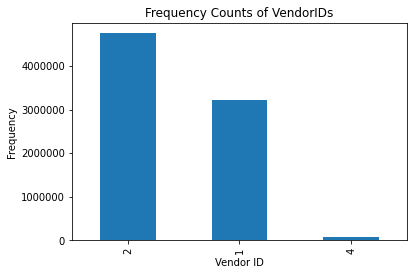

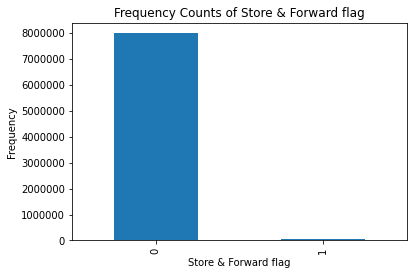

In [ ]:
plt.subplots(1, 1)
plt.ticklabel_format(style = 'plain')

ax1 = df['VendorID'].value_counts().plot(kind='bar',
                                    title="Frequency Counts of VendorIDs")
ax1.set_xlabel("Vendor ID")
ax1.set_ylabel("Frequency")

plt.show()

plt.ticklabel_format(style = 'plain')
ax2 = df['store_and_fwd_flag'].value_counts().plot(kind='bar',
                                    title="Frequency Counts of Store & Forward flag")
ax2.set_xlabel("Store & Forward flag")
ax2.set_ylabel("Frequency")

plt.show()

*Interpretation*:

The most frequent TPEP provider is **VeriFone Inc.** (over 4.5 million trips), then just over 3 million with **Creative Mobile Technologies**.

Also, most taxi trips are **not a store and forward trip**

### Continuous Variables
Let's look at the continuous variables next. 

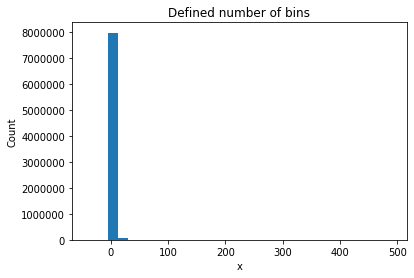

In [ ]:
plt.ticklabel_format(style = 'plain')

plt.hist(df.tip_amount, bins = 30)
plt.title ('Defined number of bins')
plt.xlabel ('x')
plt.ylabel ('Count')

plt.show()

So here is one important note. Quick and easy histograms will not tell us anything about the data, since the outliers are dragging out the x axis scale... so if I want to look at some histograms, I need to customize their x ranges, and the bins.

Let's take a look at the summary statistics of each continouous variable to decide on ranges for the bins.

In [ ]:
continuous_lst = ["trip_distance", "passenger_count", "fare_amount", "extra", "mta_tax", "tip_amount", 
                  "tolls_amount", "improvement_surcharge", "total_amount", "trip_duration_seconds"]

pd.options.display.float_format = '{:.6f}'.format  # so pd.describe() does not show 1e6

df[continuous_lst].describe()

,trip_distance,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration_seconds
count,8040133.000000,8040133.000000,8040133.000000,8040133.000000,8040133.000000,8040133.000000,8040133.000000,8040133.000000,8040133.000000,8040133.000000
mean,3.006163,1.588608,13.426214,0.322918,0.496965,1.909534,0.362011,0.299448,16.821085,1095.314160
std,3.883660,1.231233,12.648322,0.465214,0.051832,2.654874,1.806093,0.017394,15.278949,4112.609752
min,0.000000,0.000000,-800.000000,-80.000000,-0.500000,-41.000000,-20.000000,-0.300000,-800.300000,-594529.000000
25%,0.990000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.760000,407.000000
50%,1.640000,1.000000,9.500000,0.000000,0.500000,1.450000,0.000000,0.300000,12.300000,696.000000
75%,3.100000,2.000000,15.000000,0.500000,0.500000,2.460000,0.000000,0.300000,18.360000,1164.000000
max,329.630000,9.000000,7011.500000,83.000000,80.800000,490.000000,910.500000,0.300000,7012.800000,777838.000000


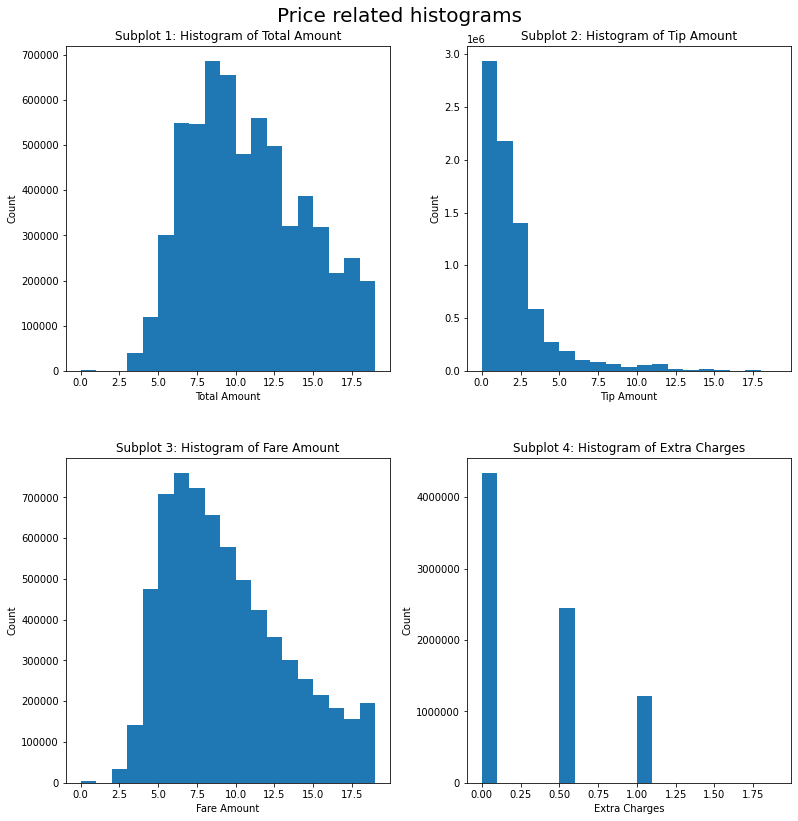

In [ ]:
fig = plt.figure(figsize=(12,12))

# Create subplot 1
ax1 = fig.add_subplot(221) # Grid of 2x2, this is suplot 1
ax1.set_xlabel('Total Amount')
ax1.set_ylabel('Count')
ax1.set_title('Subplot 1: Histogram of Total Amount')

ax1 = plt.hist(df.total_amount, bins=np.arange(0,20,1))

# Create subplot 2
ax2 = fig.add_subplot(222) # Grid of 2x2, this is suplot 2
ax2.set_xlabel('Tip Amount')
ax2.set_ylabel('Count')
ax2.set_title('Subplot 2: Histogram of Tip Amount')

ax2 = plt.hist(df.tip_amount, bins=np.arange(0,20,1))

# Create subplot 3
ax3 = fig.add_subplot(223) # Grid of 2x2, this is suplot 3
ax3.set_xlabel('Fare Amount')
ax3.set_ylabel('Count')
ax3.set_title('Subplot 3: Histogram of Fare Amount')

ax3 = plt.hist(df.fare_amount, bins=np.arange(0,20,1))

# Create subplot 4
ax4 = fig.add_subplot(224) # Grid of 2x2, this is suplot 3
ax4.set_xlabel('Extra Charges')
ax4.set_ylabel('Count')
ax4.set_title('Subplot 4: Histogram of Extra Charges')

ax4 = plt.hist(df.extra, bins=np.arange(0,2,0.1))

# Add main title
plt.suptitle('Price related histograms', size = 20)

plt.tight_layout(pad=4)
plt.ticklabel_format(style = 'plain')
plt.show()

##### Interesting EDA Result 1

Total amount is looking close to a bell shaped curved, so for some analysis this could be assumed to be almost normally distribured. I am not labelling it as normally distributed, since we would require some statistical tests that check for normality, but based on the above histrograms it's a nice little insight.

Note, since Fare Amount is closely related to Total amount, this also looks close to be normally distributed, however there seems to be an interesting little skewedness on the left side of the bell shaped curve.

Further interpretations:

The tip Amounts are left skewed, as most people give little to no tip, then there are less and less larger tips. The frequency count of tips are exponentially decreasing as the amount increases.


Also, there are a quite a lot of 0.50 and 1.00 extra charges (for rush hour and night), but most trips do not have extra charges.

##### Pickup weekday correlations

In [ ]:
index_weekday = {0:"Mon", 1:"Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}

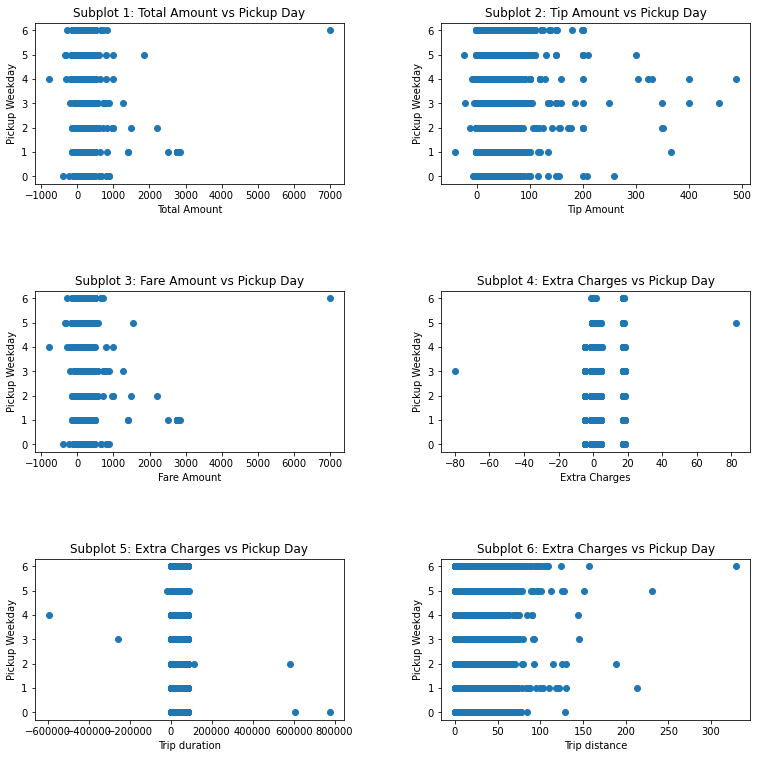

In [ ]:
fig = plt.figure(figsize=(12,12))

# Create subplot 1
ax1 = fig.add_subplot(321) # Grid of 3x2, this is suplot 1
ax1.set_xlabel('Total Amount')
ax1.set_ylabel('Pickup Weekday')
ax1.set_title('Subplot 1: Total Amount vs Pickup Day')

ax1 = plt.scatter(df.total_amount, df.pickup_weekday.rename(index=index_weekday))

# Create subplot 2
ax2 = fig.add_subplot(322) # Grid of 3x2, this is suplot 2
ax2.set_xlabel('Tip Amount')
ax2.set_ylabel('Pickup Weekday')
ax2.set_title('Subplot 2: Tip Amount vs Pickup Day')

ax2 = plt.scatter(df.tip_amount, df.pickup_weekday.rename(index=index_weekday))

# Create subplot 3
ax3 = fig.add_subplot(323) # Grid of 3x2, this is suplot 3
ax3.set_xlabel('Fare Amount')
ax3.set_ylabel('Pickup Weekday')
ax3.set_title('Subplot 3: Fare Amount vs Pickup Day')

ax3 = plt.scatter(df.fare_amount, df.pickup_weekday.rename(index=index_weekday))

# Create subplot 4
ax4 = fig.add_subplot(324) # Grid of 3x2, this is suplot 3
ax4.set_xlabel('Extra Charges')
ax4.set_ylabel('Pickup Weekday')
ax4.set_title('Subplot 4: Extra Charges vs Pickup Day')

ax4 = plt.scatter(df.extra, df.pickup_weekday.rename(index=index_weekday))

# Create subplot 5
ax5 = fig.add_subplot(325) # Grid of 3x2, this is suplot 3
ax5.set_xlabel('Trip duration')
ax5.set_ylabel('Pickup Weekday')
ax5.set_title('Subplot 5: Extra Charges vs Pickup Day')

#aggr = df.groupby('pickup_weekday').mean()['trip_duration_seconds']

ax5 = plt.scatter(df["trip_duration_seconds"], df.pickup_weekday.rename(index=index_weekday))

# Create subplot 6
ax6 = fig.add_subplot(326) # Grid of 3x2, this is suplot 3
ax6.set_xlabel('Trip distance')
ax6.set_ylabel('Pickup Weekday')
ax6.set_title('Subplot 6: Extra Charges vs Pickup Day')

#aggr = df.groupby('pickup_weekday').mean()['trip_distance']

ax6 = plt.scatter(df.trip_distance, df.pickup_weekday.rename(index=index_weekday))

plt.tight_layout(pad=6)
plt.ticklabel_format(style = 'plain')
plt.show()

##### Interesting EDA Result 2

From the plot above, the following insights can be drawn:
- Although not the highest total amounts, the middle of the week days (Wed, Thu), have high tip amounts and low fare amounts, which might indicate a correlation with the trip durations or distances;

- The trip durations vary depending on the weekday, the highest duration trips being concentrated in the Tue, Wed and Thu pickup weekdays.

##### Correlation matrix for the variables


In [ ]:
numeric_df = df.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:]

numeric_df.columns

Index(['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'trip_duration_seconds'],
      dtype='object')

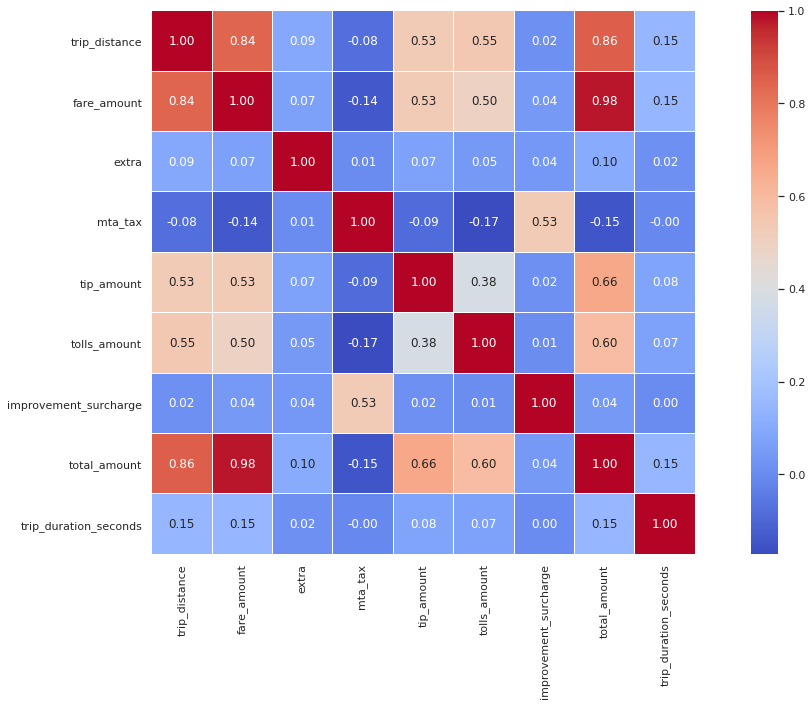

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1)
sns.heatmap(numeric_df.corr(), cbar=True, annot=True, square=True,\
                 fmt='.2f',
                 annot_kws={'size': 12}, yticklabels=numeric_df.columns,\
                 xticklabels=numeric_df.columns, cmap = 'coolwarm',lw = .1)
plt.show() 

##### Interesting EDA Result 3
Intuitively, the heatmap of the correlation matrix surfaces a **high correlation** between:
- fare amount and total amount
- the trip distance and total amount
- tip amount and total amount

Hence, the next step would be removing the total amount feature.

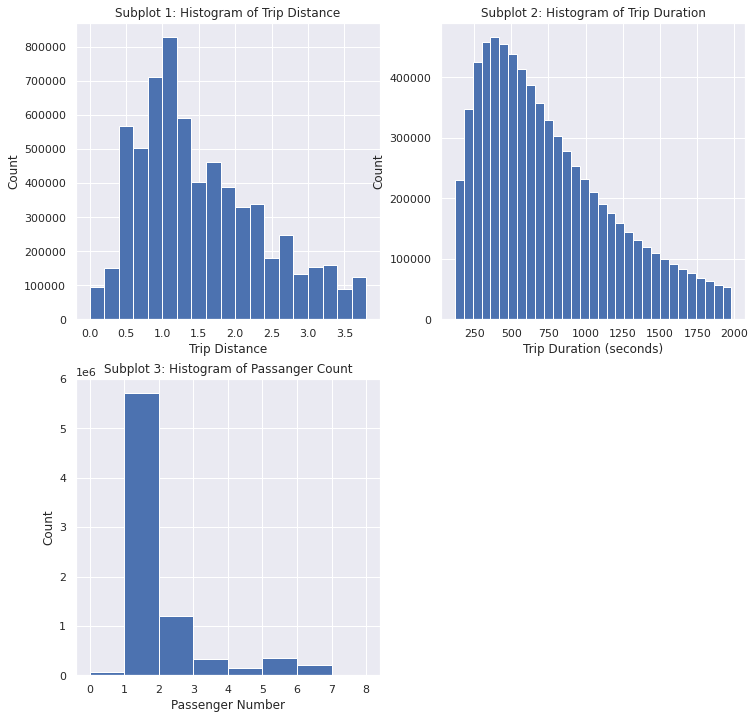

In [ ]:
fig = plt.figure(figsize=(12,12))

# Create subplot 1
ax1 = fig.add_subplot(221) # Grid of 2x2, this is suplot 1
ax1.set_xlabel('Trip Distance')
ax1.set_ylabel('Count')
ax1.set_title('Subplot 1: Histogram of Trip Distance')

ax1 = plt.hist(df.trip_distance, bins=np.arange(0,4,0.2))

# Create subplot 2
ax2 = fig.add_subplot(222) # Grid of 2x2, this is suplot 2
ax2.set_xlabel('Trip Duration (seconds)')
ax2.set_ylabel('Count')
ax2.set_title('Subplot 2: Histogram of Trip Duration')

ax2 = plt.hist(df.trip_duration_seconds, bins=np.arange(120,2000,60))

# Create subplot 3
ax3 = fig.add_subplot(223) # Grid of 2x2, this is suplot 3
ax3.set_xlabel('Passenger Number')
ax3.set_ylabel('Count')
ax3.set_title('Subplot 3: Histogram of Passanger Count')

ax3 = plt.hist(df.passenger_count, bins=np.arange(0,9,1))

##### Interesting EDA Result 4

Trip Duration is looking like a left-skewed bell shaped curved. The distribution of times looks so smooth, that it almost looks like the right side of the curve is uniformly decreasing. We further investigate below the very clean left skewed normal distribution shaped histogram indicated by the long right tale.

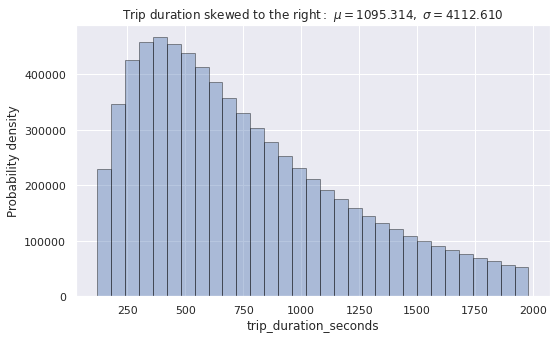

In [ ]:
from scipy.stats import norm
# Mean 
mu = df.trip_duration_seconds.mean()

# Standard deviation
sigma = df.trip_duration_seconds.std()
bins = np.arange(120,2000,60)
fig = plt.figure(figsize=(8.5, 5))
plt.hist(df.trip_duration_seconds, edgecolor = 'black', lw = 1, alpha = .40, bins=np.arange(120,2000,60))
# Normal Distribution
y = norm.pdf(bins, mu, sigma)
#plt.plot(b, y, 'r--', linewidth=2)
plt.xlabel('trip_duration_seconds')
plt.ylabel('Probability density')

plt.title(r'$\mathrm{Trip\ duration\ skewed \ to \ the \ right:}\ \mu=%.3f,\ \sigma=%.3f$'%(mu,sigma))
plt.grid(True)

plt.show()

### Exploratory pair-wise scatter plots

I do believe in efficiency of a task, so in my work, whereever I can, I include open source implementations, or automations which make my work as a data scientist easier, and more efficient.

One of these efficiencies that I started a while ago is automated EDA libraries such as Autoviz, Sweetviz, and pandas-profiling. I let these automated EDA visualization tools guide my EDA, not do my EDA. 

I find it insightful to analyze as many plots as I can about relationships in the data, and when I see something that catches my eyes, then I dig deeper into the data, and I have a closer look. This is what I will try doing for the rest of this EDA task.  Instead of me coding up all possible permurtations of pairwise scatter plots, I would rather have a tool show me all possible plots, then I can choose what to pay more attention to in the data.

Imported AutoViz_Class version: 0.0.81. Call using:
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
Note: verbose=0 or 1 generates charts and displays them in your local Jupyter notebook.
      verbose=2 saves plots in your local machine under AutoViz_Plots directory and does not display charts.
Shape of your Data Set: (8040133, 21)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  9
    Number of Integer-Categorical Columns =  7
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  1
    Number of Numeric-Boolean Columns =  1
    Number of Discrete String Columns =  2
    Number of NLP String Columns = 

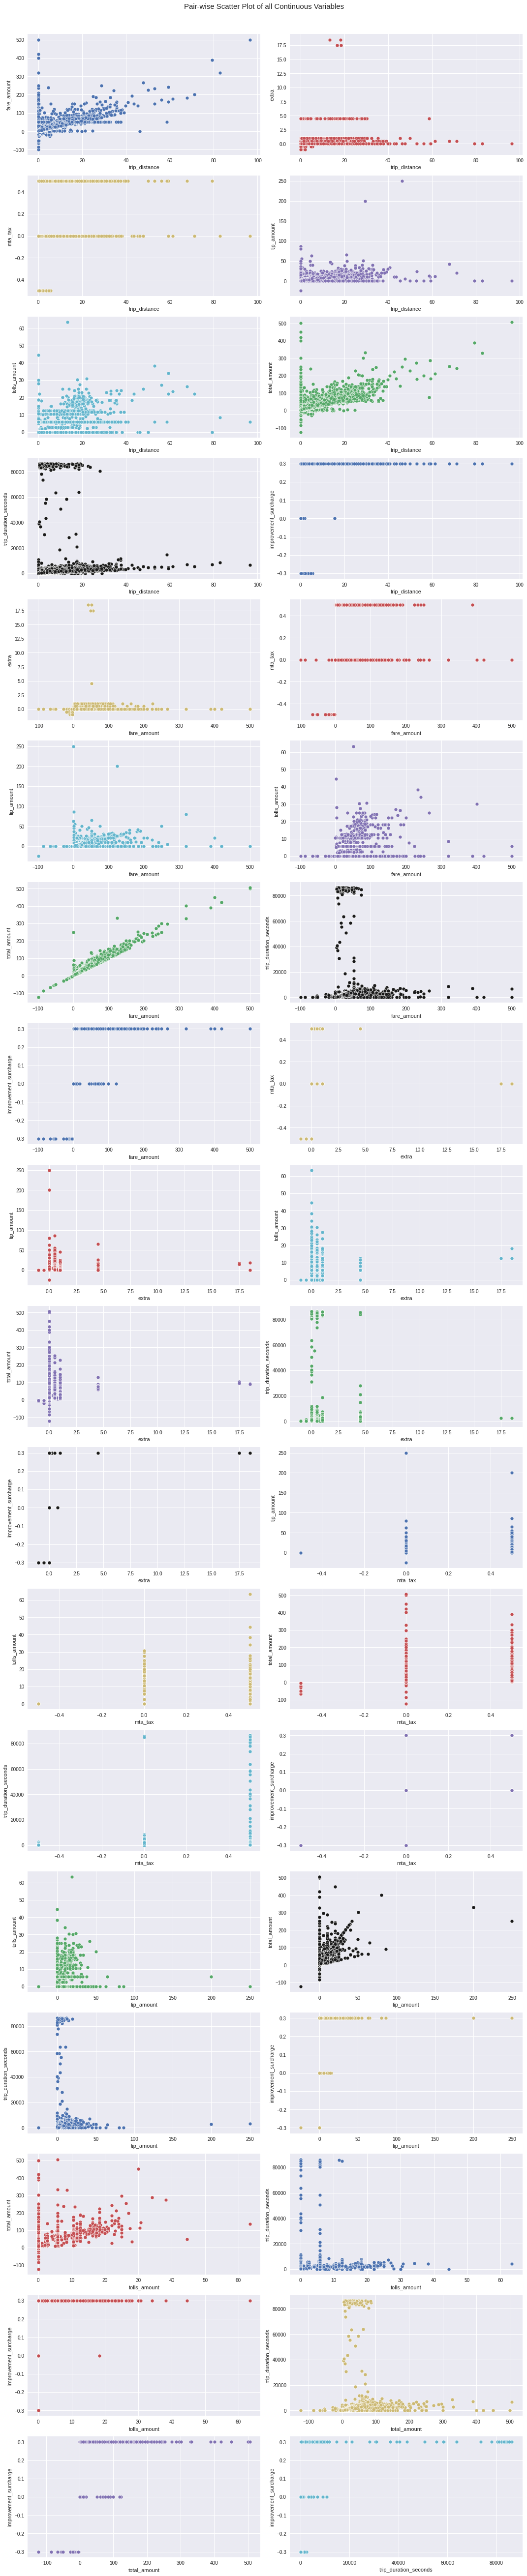

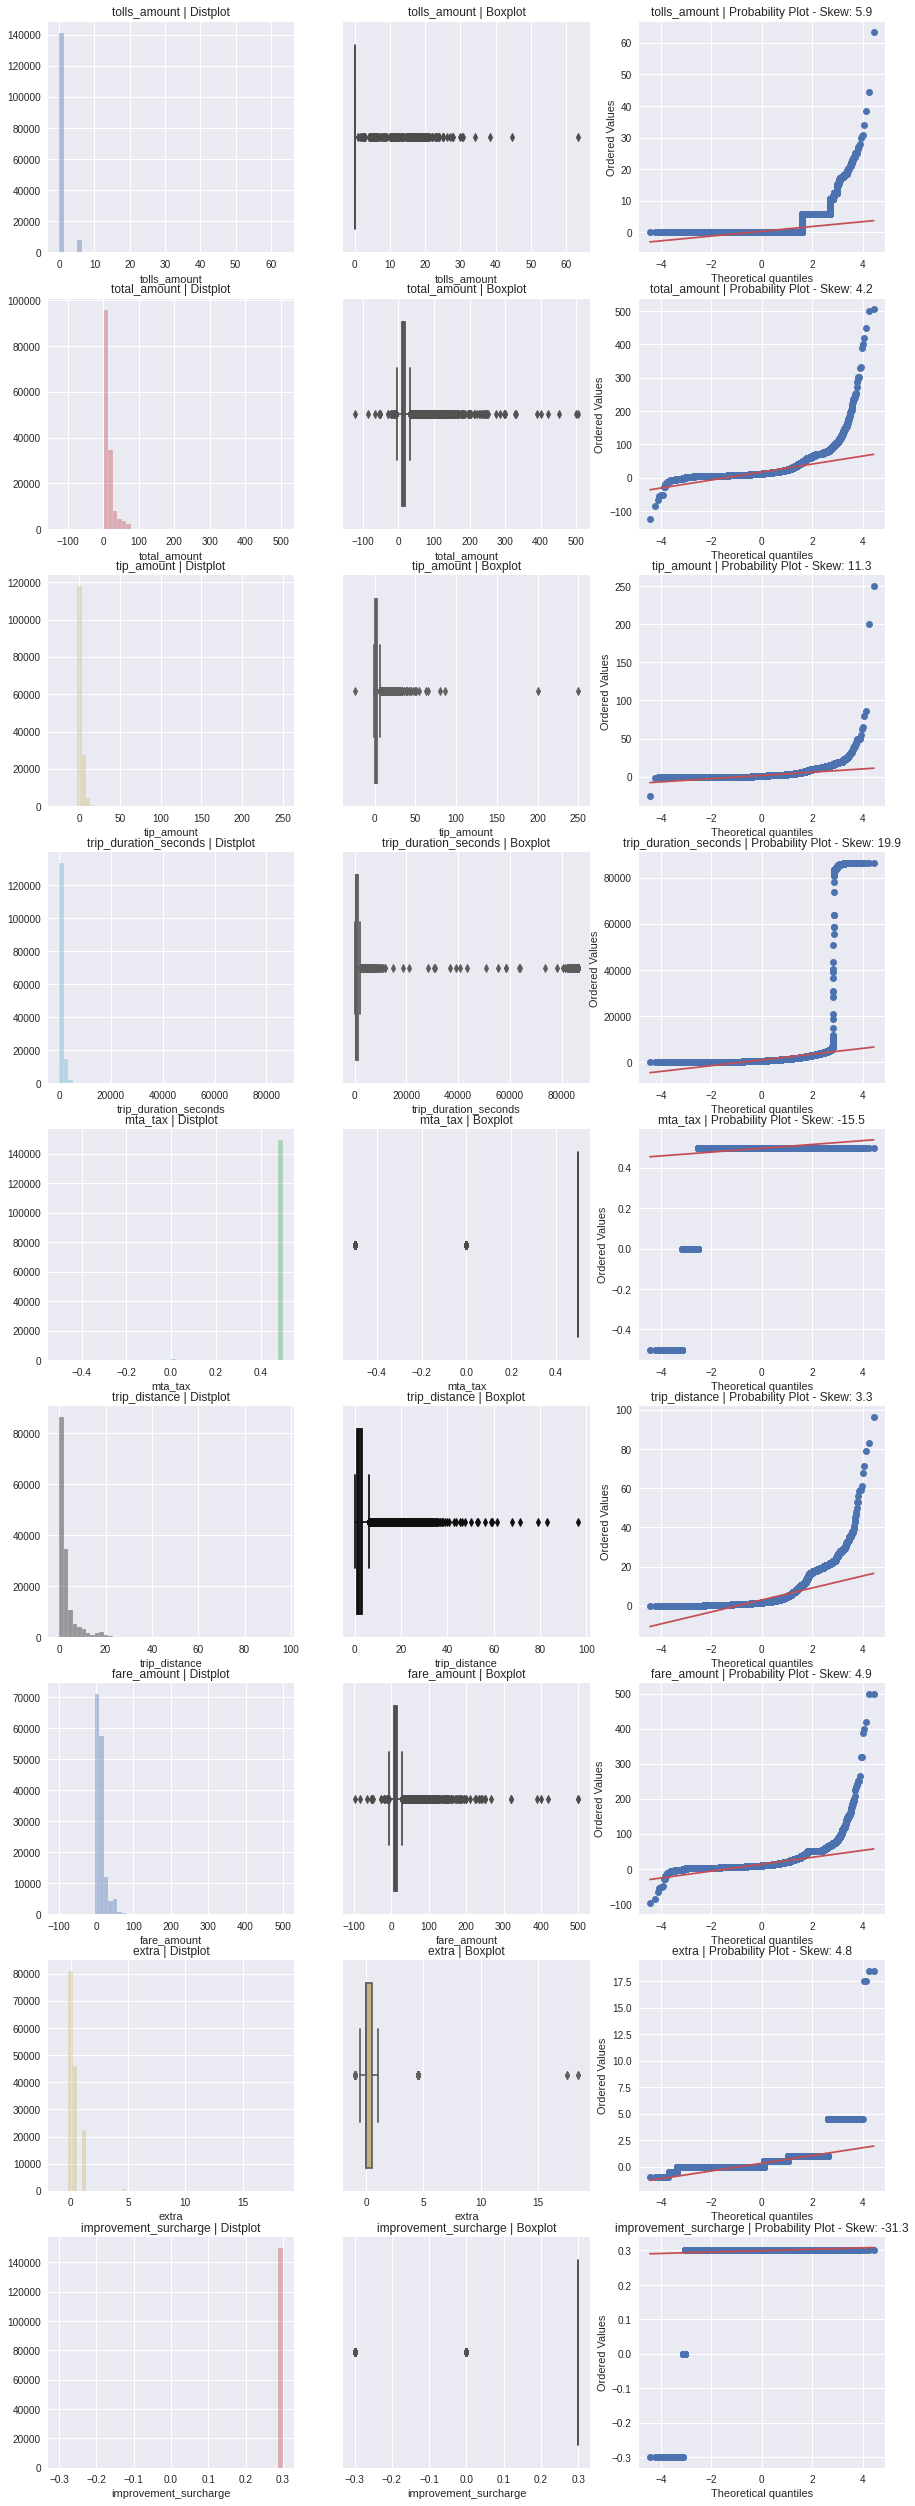

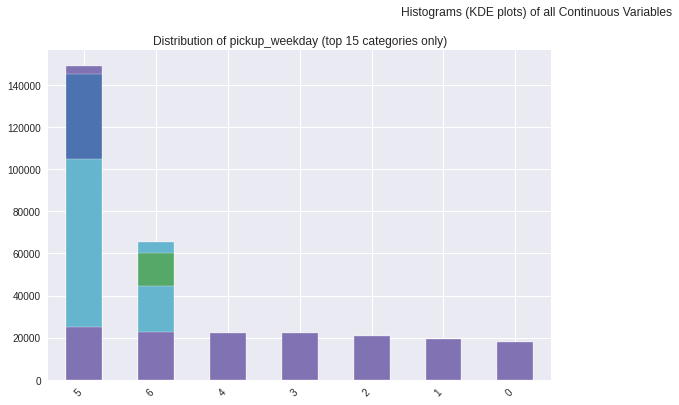

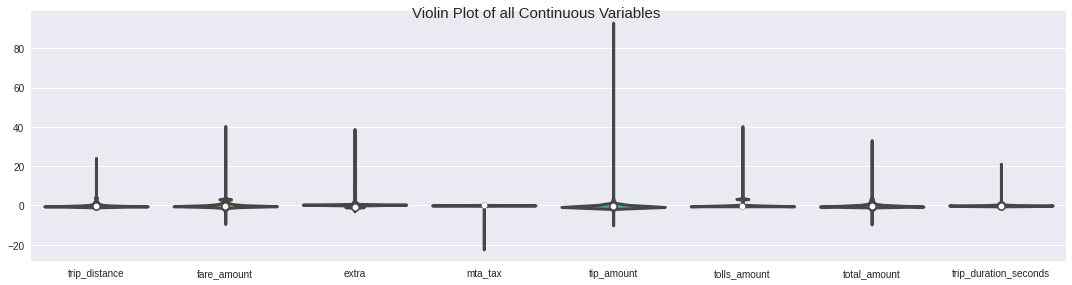

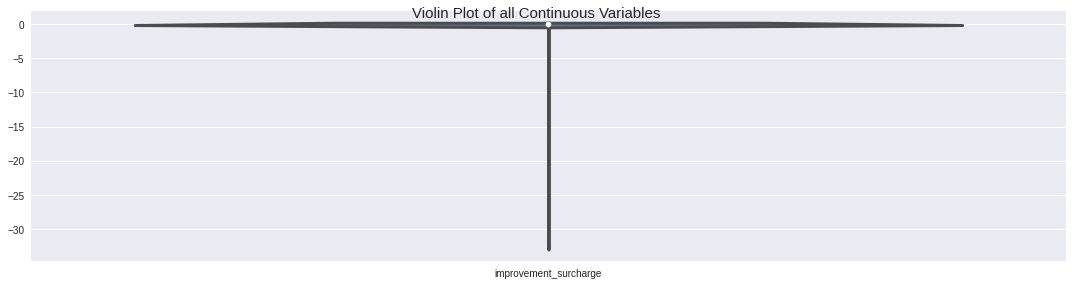

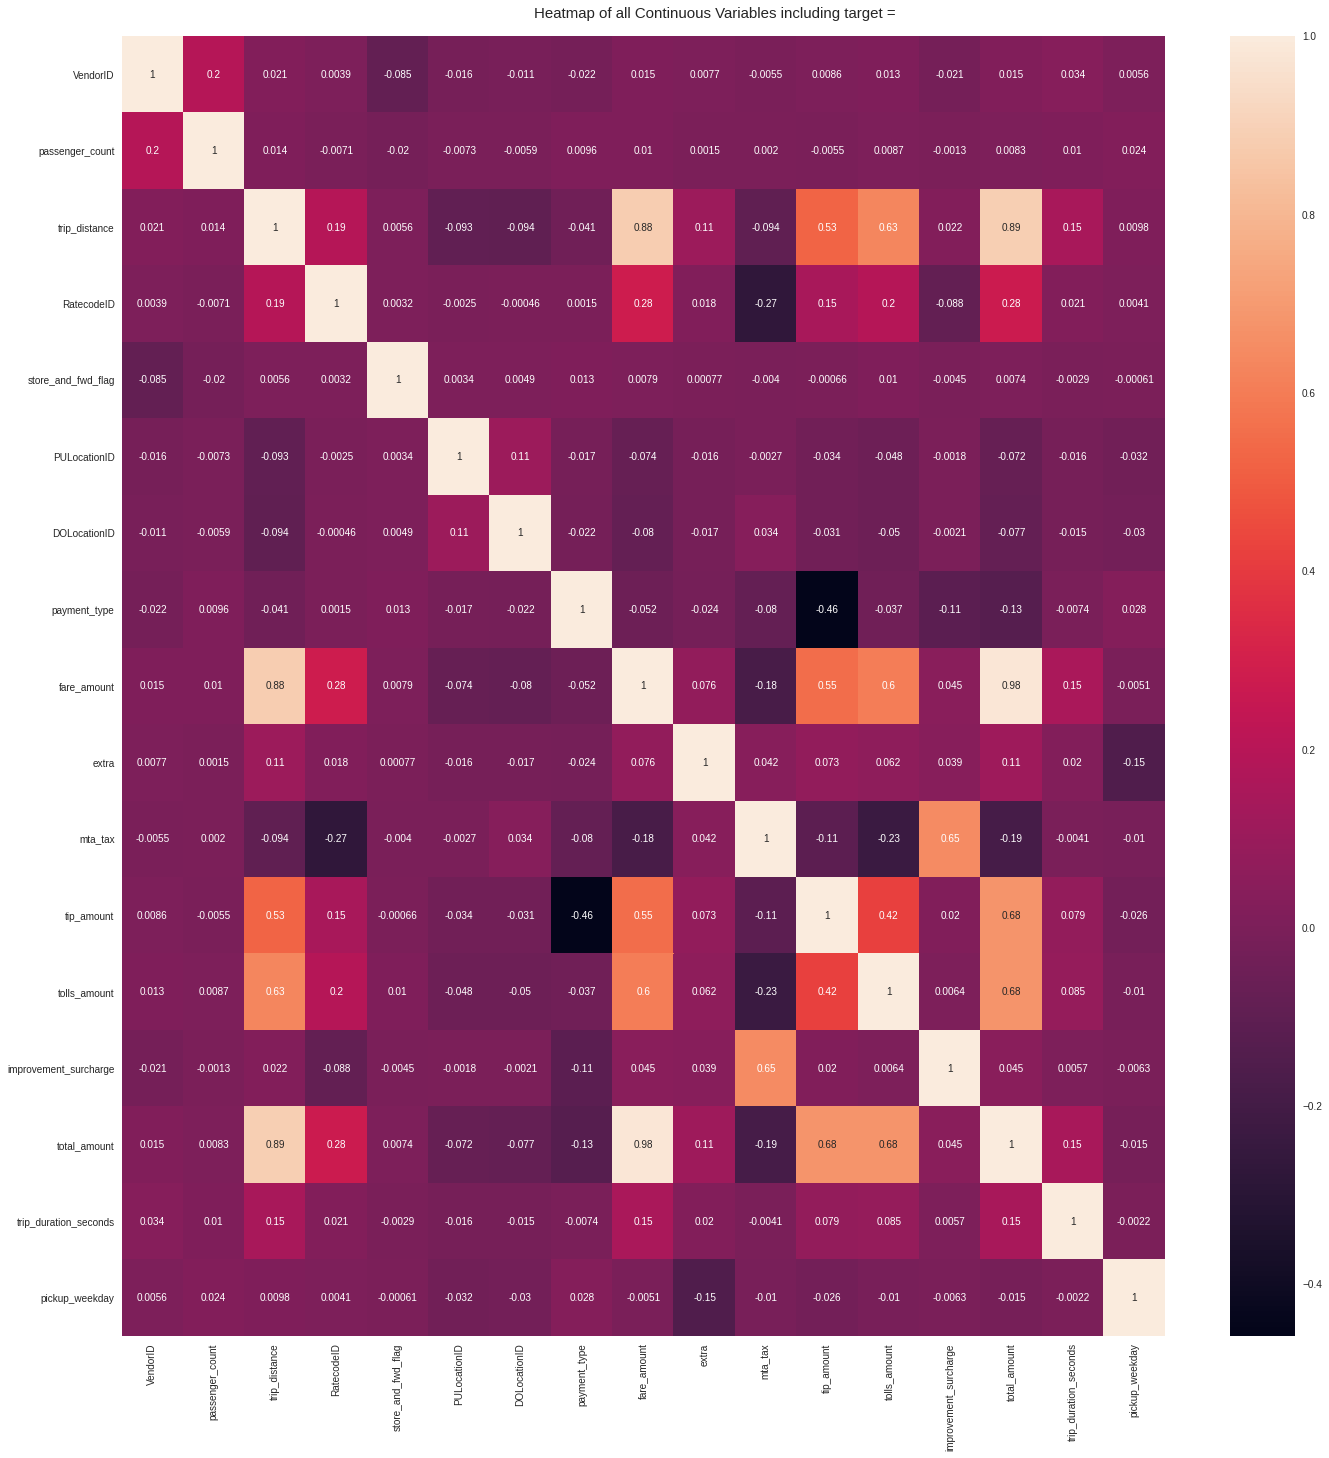

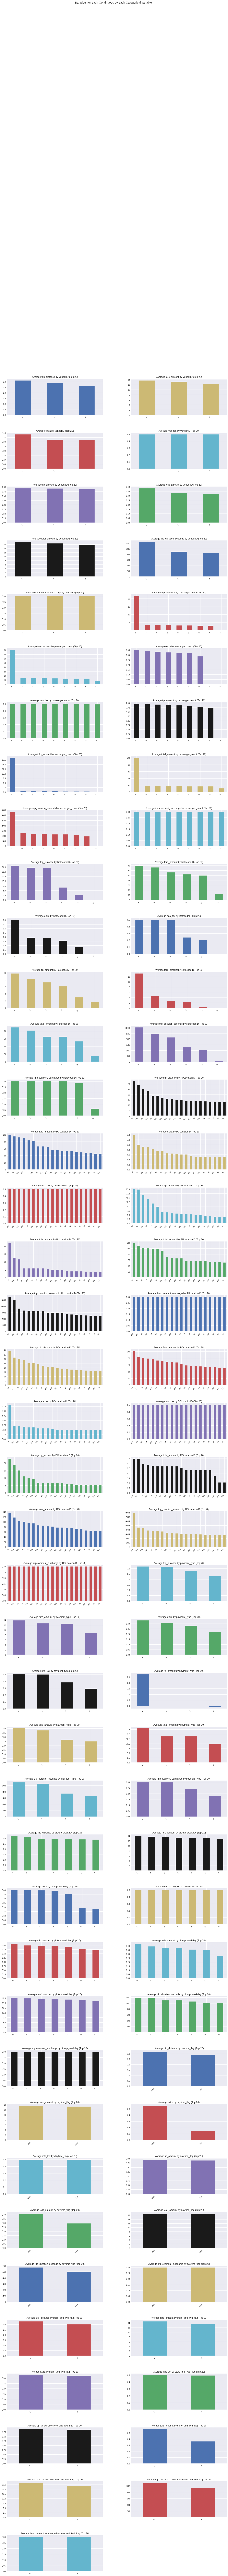

Time to run AutoViz (in seconds) = 141.240

 ###################### VISUALIZATION Completed ########################


In [ ]:
from autoviz.AutoViz_Class import AutoViz_Class

# write improved, cleaning data set to csv
# df.to_csv("/content/drive/MyDrive/Datasets/yellow_tripdata_2018-09_improved.csv")

#EDA using Autoviz
autoviz = AutoViz_Class().AutoViz("/content/drive/MyDrive/Datasets/yellow_tripdata_2018-09_improved.csv")

##### Interesting EDA Result 5

Notes on the above visualizations:
- the average tip is significantly higher for the credit card paying customers, although the average fare amount is relatively equal amongst the payment types

- the average trip distance is relatively equal for low number of passengers, but has a significantly higher value for 8-passenger trips

- the correlation between trip distance, trip duration, tip amount and total amount analyzed in the previous heat map is reocurring now as a line shape (y=x) in the pairwise plots

- the violin plots of the continuous variables gives us the first hints about the features that have outliers (such as tip amount, mta_tax, improvement_surcharge)

## Task 2: Pick Up Location Ranking

For this task I have thought about an algorithmic/analytical approach to rank pick up locations based on a custom evaluation metric calculated by me.

I considered that I want to consult some subject matter "experts" on their domain knowledge about taxi rides. My brother is a taxi driver, and I asked him what are the most important characteristics of a trip that he would consider when deciding on a pick up location. THis is what he told me:


*   Trip Distance is not necessarity a good indicator for a good trip, as the further you drive a passenger, the further you have to drive back from, and if you got into a different district/city, then you have higher chances of driving back to your pick up location alone

*   He thought that **fair amount is probably the most important characteristic of a trip**, as he works on a commision, so he would get a good chunk of that fair amount, even if the passenger did not leave a tip

*   **Second most important characteristic would be the tip amount** (for obvious reasons, more money in his pocket)

*   Third most important aspect would be trip duration, as the longer the trip lasts, the larger the total amount will be. Note that we saw in the EDA section (and I will show again below) that fair amount and trip duration do not necessarily have a linear relationship, as there is a large group of trips are not linearly correlated in their trip duration and fare amount values. 

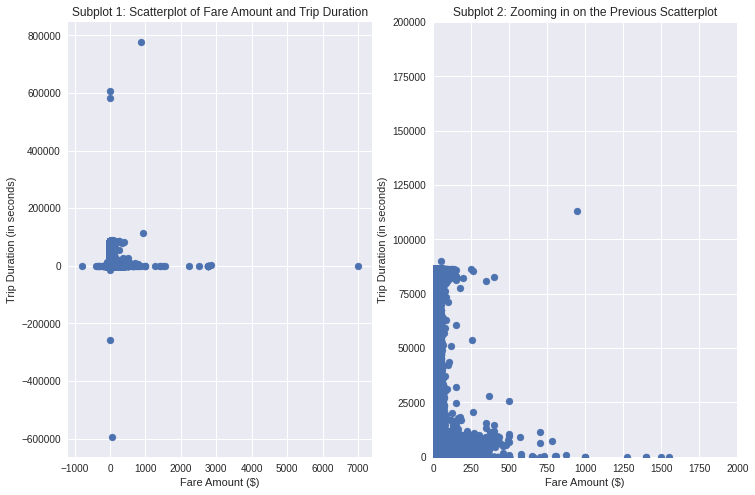

In [ ]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(121) # Grid of 1x2, this is suplot 1
ax1.set_xlabel('Fare Amount ($)')
ax1.set_ylabel('Trip Duration (in seconds)')
ax1.set_title('Subplot 1: Scatterplot of Fare Amount and Trip Duration')
ax1 = plt.scatter(df.fare_amount, df.trip_duration_seconds)

# zooming in 
ax2 = fig.add_subplot(122) # Grid of 1x2, this is suplot 2
ax2.set_xlabel('Fare Amount ($)')
ax2.set_ylabel('Trip Duration (in seconds)')
ax2.set_xlim(0, 2000)
ax2.set_ylim(0, 200000)
ax2.set_title('Subplot 2: Zooming in on the Previous Scatterplot')

ax2 = plt.scatter(df.fare_amount, df.trip_duration_seconds)

Thus, this is what I have in mind:

Best_trip_metric = 0.5 * (Scaled Fair Amount) + 0.3 * (Scaled Tip Amount) + 0.2 * (Scaled Trip Duration Amount)

This metric is a weighted metric to incorporate a somewhat subjective characteristic priority list, which allows more important trip characteristics to be get more heavily weighted.


Since the range of values of 3 trip characteristics, we need to re-scale (normalize) the data. I want to choose a standard rescaling of the 3 trip characteristic, since they are not on the same scale. This is needed, because of the following example:

e.g. 0.5 x ($100) + 0.3 x ($1.20) + 0.2 x (300 sec) .... this would cause a very unbalanced, biased metric, since the features are not measured on the same scale

Then, finally we would take our data set, group by each existing pick up location, and calculate the **average** *Best_trip_metric* metric, then rank them in decreasing order, and we got our **data-driven** *top-n* pick up locations.

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

best_trip_features_scaled = pd.DataFrame(std_scaler.fit_transform(df[["fare_amount", "tip_amount", "trip_duration_seconds"]]))

best_trip_features_scaled.columns = ["fare_amount", "tip_amount", "trip_duration_seconds"]
best_trip_features_scaled.describe()

,fare_amount,tip_amount,trip_duration_seconds
count,8040133.000000,8040133.000000,8040133.000000
mean,0.000000,-0.000000,-0.000000
std,1.000000,1.000000,1.000000
min,-64.311005,-16.162548,-144.828804
25%,-0.547599,-0.719256,-0.167367
50%,-0.310414,-0.173091,-0.097095
75%,0.124426,0.207342,0.016701
max,553.280862,183.846925,188.868573


Everything looks good. THis is what I wanted it to look like. Mean of 0, std dev of 1. These features have been normalized.

In [ ]:
best_trip_features_scaled.head()

,fare_amount,tip_amount,trip_duration_seconds
0,-0.468538,-0.719256,-0.146455
1,-0.547599,0.034076,-0.170771
2,-0.547599,-0.719256,-0.171014
3,-0.389476,-0.342590,-0.146455
4,-0.705723,-0.286090,-0.223779


In [ ]:
my_best_trip_ranking = 0.5 * best_trip_features_scaled["fare_amount"] + 0.3 * best_trip_features_scaled["tip_amount"] + 0.2 * best_trip_features_scaled["trip_duration_seconds"]

df["best_trip_ranking"] = my_best_trip_ranking

In [ ]:
PULocation_aggregatedRanking = df.groupby('PULocationID').mean()['best_trip_ranking']
PULocation_aggregatedRanking

PULocationID
1      3.394541
2      1.089230
3      0.552754
4     -0.083115
5      2.403743
         ...   
261    0.182776
262   -0.164297
263   -0.193670
264    0.048410
265    2.922242
Name: best_trip_ranking, Length: 263, dtype: float64

In [ ]:
PULocation_aggregatedRanking.sort_values(ascending=False)

PULocationID
204    6.215216
44     4.134718
1      3.394541
265    2.922242
176    2.667422
         ...   
237   -0.219549
207   -0.268134
110   -0.274388
193   -0.326240
199   -0.659296
Name: best_trip_ranking, Length: 263, dtype: float64

### The result of my analysis on best pick up locations

Also, I looked up what these IDs map to in the taxi+_zone_lookup.csv

Top 5 best location IDs:

1.  204 ---> Borough = Staten Island ....... zone = Rossville/Woodrow
2.  44 ---> Borough = Staten Island ........ Zone = Charleston/Tottenville
3.  1 ----> Borough = EWR .................. zone = Newark Airport
4.  265 ---> Borough = Unknown ............. zone = N/A (unfortunately)
5.  176 ---> Borough = Staten Island ....... zone = Oakwood



---



Top 5 worst location IDs:
1.  199 ---> Borough = Queens ................. zone = Ridgewood
2.  193 ---> Borough = Queens ................. zone = Queensbridge/Ravenswood
3.  110 ---> Borough = Staten Island ................. zone = Great Kills Park
4.  207 ---> Borough = Queens .............. zone = Saint Michaels Cemetery/Woodside
5.  237 ---> Borough = Manhattan ................. zone = Upper East Side South



### In conclusion

Based on my analysis and my custom metric the best places to pick up passengers are in **Staten Island** (*Rossville/Woodrow, Charleston/Tottenville, Oakwood*) and at the **Neward Airport**.

## Task 3: Fraud Detection

For this fraud detection system I have thought about 2 approaches:

1.   Manually looking at each numerical variable and decide on a threshold that is a reasonable value for that field. Anything that is above (or below) that threshold value should be flagged to be investigated for potential fraud


> This approach is purely based on thresholding, and subjectively deciding/judging what is a reasonable/unreasonable value. E.g. I noticed that there are plenty of negative (sub-zero) fare amounts in the data set. Maybe these are refunds, maybe they are human error, or maybe they are potential frauds 

2.   Performing outlier detection using common outlier detection algorithms such as Local Outlier Factor, and Isolation Forest



I am leaning towards the second approach, with actual outlier detection algorithms, since they are more algorithmic, and less subjective than my own theresholding skills

### Method 1: Local Outlier Factor

This is a simple approach to identifying outliers by locating those examples that are far from the other examples in the feature space.

This can work well for feature spaces with low dimensionality (few features), but it can become less reliable as the number of features is increased, due to the curse of dimensionality.

The local outlier factor algorithm is using the idea of nearest neighbors for outlier detection. Each sample is assigned a score of how isolated or how likely it is to be outliers based on the size of its local neighborhood. The  examples with the largest scores are more likely to be outliers.

In [ ]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'trip_duration_seconds', 'daytime_flag',
       'pickup_weekday', 'best_trip_ranking'],
      dtype='object')

This is the full feature list that I want to use in a multi-variate outlier detection ... but I can't. My laptop is not powerful enough to run outlier detection against all these variables... so I am choosing a subset of variables which seem more relevant to fraud, and hopefully my laptop will be able to successfully run it

UPDATE: I still can't run these algorithms on the data, since it crashes my memory, but I will try to take a random sample from the data, and execute it on that


In [ ]:
#features_to_include = ['VendorID','passenger_count', 'trip_distance', 'RatecodeID', 
#                       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
#                       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
#                       'total_amount', 'trip_duration_seconds', 'daytime_flag', 'pickup_weekday']

random_sample = df.sample(n = 100000, random_state = 2021)  # let's take a 100.000 random sample, instead of 8 million in the original data set

features_to_include = ['trip_distance', 'payment_type', 'fare_amount', 'extra',
                       'tip_amount', 'tolls_amount','total_amount', 'trip_duration_seconds']

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# identify outliers in the dataset
lof = LocalOutlierFactor()

yhat = lof.fit_predict(random_sample[features_to_include])

# select all rows that are outliers
mask = yhat == -1

LOF_outliers = random_sample.loc[mask, :]

#### Outliers detected by the Local Outlier Factor Algorithm

In [ ]:
LOF_outliers


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration_seconds,daytime_flag,pickup_weekday,best_trip_ranking
7055850,1,2018-09-27 15:05:06,2018-09-27 15:15:02,1,0.900000,1,0,186,230,1,8.000000,0.000000,0.500000,7.000000,0.000000,0.300000,15.800000,596.000000,True,3,0.336436
1159958,2,2018-09-06 02:26:13,2018-09-06 02:42:01,1,5.350000,5,0,158,265,1,47.000000,0.000000,0.500000,11.660000,10.500000,0.300000,69.960000,948.000000,False,3,2.421839
2726937,2,2018-09-11 19:41:43,2018-09-11 19:45:32,6,1.650000,1,0,236,75,1,6.500000,1.000000,0.500000,1.660000,0.000000,0.300000,9.960000,229.000000,False,1,-0.344127
6173025,2,2018-09-24 01:38:32,2018-09-24 01:48:50,1,3.710000,1,0,107,33,1,12.500000,0.500000,0.500000,4.140000,0.000000,0.300000,17.940000,618.000000,False,0,0.192216
3049398,1,2018-09-12 21:25:44,2018-09-12 21:25:44,1,0.000000,1,0,62,264,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,2,-0.799794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954119,1,2018-09-05 12:39:29,2018-09-05 13:26:31,1,24.500000,1,0,48,101,1,69.500000,0.000000,0.500000,11.410000,5.760000,0.300000,87.470000,2822.000000,True,2,3.374170
5688378,2,2018-09-22 05:06:13,2018-09-22 05:06:17,1,0.000000,5,0,265,265,2,440.900000,0.000000,0.000000,0.000000,0.000000,0.300000,441.200000,4.000000,False,5,16.629592
419010,1,2018-09-03 04:14:36,2018-09-03 04:23:02,1,3.900000,1,0,143,152,2,13.000000,0.500000,0.500000,0.000000,0.000000,0.300000,14.300000,506.000000,False,0,-0.261284
5463609,1,2018-09-21 13:54:20,2018-09-21 14:33:06,1,17.300000,3,0,234,1,1,68.500000,0.000000,0.000000,15.000000,16.950000,0.300000,100.750000,2326.000000,True,4,3.716187


### Method 2: Isolation Forest

Isolation Forest is a tree-based anomaly detection algorithm.

The model is trying to isolate anomalies that are both few in number and different in the feature space.

In [ ]:
from sklearn.ensemble import IsolationForest

# identify outliers in the dataset
iso = IsolationForest(contamination=0.01) # I will assume a fraud rate of 1% ... maybe that is even too large

yhat = iso.fit_predict(random_sample[features_to_include])

# select all rows that are outliers
mask = yhat == -1

iso_outliers = random_sample.loc[mask, :]

#### Outliers detected by the Isolation Forest Algorithm

In [ ]:
iso_outliers

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration_seconds,daytime_flag,pickup_weekday,best_trip_ranking
1252850,2,2018-09-06 12:57:11,2018-09-06 13:22:20,2,16.260000,3,0,100,1,1,61.500000,0.000000,0.000000,14.460000,10.500000,0.300000,86.760000,1509.000000,True,3,3.338719
1672076,2,2018-09-07 19:48:16,2018-09-07 20:36:40,2,15.060000,3,0,68,1,1,67.000000,1.000000,0.000000,10.000000,10.500000,0.300000,88.800000,2904.000000,False,4,3.120000
522273,2,2018-09-03 17:16:55,2018-09-03 18:05:38,1,23.430000,1,0,132,115,1,65.000000,0.000000,0.500000,0.000000,11.520000,0.300000,77.320000,2923.000000,True,0,1.911866
4391465,1,2018-09-17 16:37:28,2018-09-17 17:30:14,1,16.500000,2,0,132,233,1,52.000000,4.500000,0.500000,12.600000,5.760000,0.300000,75.660000,3166.000000,True,0,2.833577
1298702,1,2018-09-06 14:22:47,2018-09-06 15:32:50,1,23.300000,1,0,132,220,2,70.500000,0.000000,0.500000,0.000000,5.760000,0.300000,77.060000,4203.000000,True,3,2.191533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706918,2,2018-09-18 19:22:58,2018-09-18 19:51:28,1,16.400000,2,0,130,87,1,52.000000,4.500000,0.500000,12.610000,5.760000,0.300000,75.670000,1710.000000,False,1,2.763900
6244973,2,2018-09-24 12:46:38,2018-09-24 13:29:22,5,29.010000,4,0,138,265,1,121.500000,0.000000,0.500000,24.460000,0.000000,0.300000,146.760000,2564.000000,True,0,6.891878
4893498,2,2018-09-19 14:40:37,2018-09-19 15:21:42,1,23.060000,1,0,132,212,2,62.500000,0.000000,0.500000,0.000000,5.760000,0.300000,69.060000,2465.000000,True,2,1.790765
954119,1,2018-09-05 12:39:29,2018-09-05 13:26:31,1,24.500000,1,0,48,101,1,69.500000,0.000000,0.500000,11.410000,5.760000,0.300000,87.470000,2822.000000,True,2,3.374170


### Alternative method: One-Class SVM

When using the one-class variation, SVM captures the density of the majority class and classifies samples on the extremes of the density function as outliers.

Even though SVM is a classification algorithm and One-Class SVM is also a classification algorithm, it can be used to discover outliers in input data for both regression and classification datasets.

In [ ]:
from sklearn.svm import OneClassSVM

svm = OneClassSVM(nu=0.01) # I will assume a fraud rate of 1% ... maybe that is even too large

yhat = svm.fit_predict(df[features_to_include])

# select all rows that are outliers
mask = yhat == -1

svm_outliers = df.loc[mask, :]

The safest way to be somewhat sure that there is a potential fraud going on is to check .. but we can not do that via code. So what I decided to do is to cross-reference all the potential outliers flagged by the 3 algorithms and let's see if there are any taxi trips that have been flagged by all 3

### Fraud Detection Results

In [ ]:
cross_reference1 = pd.merge(LOF_outliers, iso_outliers, how='inner', on=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
cross_reference1

,VendorID_x,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count_x,trip_distance_x,RatecodeID_x,store_and_fwd_flag_x,PULocationID_x,DOLocationID_x,payment_type_x,fare_amount_x,extra_x,mta_tax_x,tip_amount_x,tolls_amount_x,improvement_surcharge_x,total_amount_x,trip_duration_seconds_x,daytime_flag_x,pickup_weekday_x,best_trip_ranking_x,VendorID_y,passenger_count_y,trip_distance_y,RatecodeID_y,store_and_fwd_flag_y,PULocationID_y,DOLocationID_y,payment_type_y,fare_amount_y,extra_y,mta_tax_y,tip_amount_y,tolls_amount_y,improvement_surcharge_y,total_amount_y,trip_duration_seconds_y,daytime_flag_y,pickup_weekday_y,best_trip_ranking_y
0,1,2018-09-20 16:19:56,2018-09-20 17:24:39,1,18.000000,3,0,230,265,1,77.500000,1.000000,0.000000,20.760000,25.000000,0.300000,124.560000,3883.000000,True,3,4.798562,1,1,18.000000,3,0,230,265,1,77.500000,1.000000,0.000000,20.760000,25.000000,0.300000,124.560000,3883.000000,True,3,4.798562
1,2,2018-09-26 12:46:27,2018-09-26 13:18:48,1,20.300000,3,0,161,1,1,72.500000,0.000000,0.000000,22.260000,16.260000,0.300000,111.320000,1941.000000,True,2,4.675965,2,1,20.300000,3,0,161,1,1,72.500000,0.000000,0.000000,22.260000,16.260000,0.300000,111.320000,1941.000000,True,2,4.675965
2,1,2018-09-18 20:38:23,2018-09-18 21:27:58,2,30.400000,1,0,161,204,1,82.000000,0.500000,0.500000,5.000000,26.500000,0.300000,114.800000,2975.000000,False,1,3.151419,1,2,30.400000,1,0,161,204,1,82.000000,0.500000,0.500000,5.000000,26.500000,0.300000,114.800000,2975.000000,False,1,3.151419
3,1,2018-09-05 08:07:24,2018-09-05 08:57:28,1,19.600000,3,0,236,1,1,75.000000,0.000000,0.000000,8.000000,17.500000,0.300000,100.800000,3004.000000,True,2,3.215112,1,1,19.600000,3,0,236,1,1,75.000000,0.000000,0.000000,8.000000,17.500000,0.300000,100.800000,3004.000000,True,2,3.215112
4,2,2018-09-29 00:34:58,2018-09-29 01:25:30,2,25.940000,1,0,100,155,1,73.000000,0.500000,0.500000,8.880000,0.000000,0.300000,83.180000,3032.000000,False,5,3.236851,2,2,25.940000,1,0,100,155,1,73.000000,0.500000,0.500000,8.880000,0.000000,0.300000,83.180000,3032.000000,False,5,3.236851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,2,2018-09-27 09:47:48,2018-09-27 10:48:30,1,36.890000,5,0,132,265,1,130.000000,0.000000,0.500000,20.000000,27.020000,0.300000,177.820000,3642.000000,True,3,6.776336,2,1,36.890000,5,0,132,265,1,130.000000,0.000000,0.500000,20.000000,27.020000,0.300000,177.820000,3642.000000,True,3,6.776336
278,2,2018-09-29 16:08:20,2018-09-29 16:35:03,1,9.760000,5,0,163,265,1,100.000000,0.000000,0.000000,22.560000,12.500000,0.300000,135.360000,1603.000000,True,5,5.780529,2,1,9.760000,5,0,163,265,1,100.000000,0.000000,0.000000,22.560000,12.500000,0.300000,135.360000,1603.000000,True,5,5.780529
279,2,2018-09-24 12:46:38,2018-09-24 13:29:22,5,29.010000,4,0,138,265,1,121.500000,0.000000,0.500000,24.460000,0.000000,0.300000,146.760000,2564.000000,True,0,6.891878,2,5,29.010000,4,0,138,265,1,121.500000,0.000000,0.500000,24.460000,0.000000,0.300000,146.760000,2564.000000,True,0,6.891878
280,1,2018-09-05 12:39:29,2018-09-05 13:26:31,1,24.500000,1,0,48,101,1,69.500000,0.000000,0.500000,11.410000,5.760000,0.300000,87.470000,2822.000000,True,2,3.374170,1,1,24.500000,1,0,48,101,1,69.500000,0.000000,0.500000,11.410000,5.760000,0.300000,87.470000,2822.000000,True,2,3.374170


In [ ]:
import statistics

statistics.mean(random_sample["trip_distance"])

3.0023659

From a random sample of 100.000 taxi trips there are a total of 282 that have been flagged as outliers by both outlier detection algorithms. This gives a strong suggestion that these trips need to be investigated by a human, preferably from the fraud detection department, then some decisions could be made.

Just by taking a quick look at the outliers, what sticks out is the large trip_distances that almost all these trips have in common ( e.g 25.94 miles, 29.01 miles, 36.89 miles), while the mean trip distance is 3 miles for this random sample.

## Task 4: Fare Amount Prediction

In [ ]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'trip_duration_seconds', 'daytime_flag',
       'pickup_weekday', 'best_trip_ranking'],
      dtype='object')

In [ ]:
# these are the features that I can and would like to conside
features_to_include = ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
                       'PULocationID', 'DOLocationID', 'payment_type', 'extra',
                       'tolls_amount', 'tip_amount','trip_duration_seconds', 'daytime_flag', 'pickup_weekday']

# Features that I have removed include:
#     - pickup and drop off timestamp (can't have timestamp in an ML model) .. but I have daytime flag and pickup_weekday
#     - total_amount - since it's correlated with fare-amount, and if you would knoe total_amount, you can easy guess the fare amount
#     - improvement_surcharge - this is a constant charge, so it should not be in the predictive model
#     - tax - as far as I know tax is constant a constant percentage for everyone, which means that fare_amount could be calculated from the tax amount being paid

**NOTE**: I tried running ML models on the whole data set, but I do not have enough RAM to store do the computations on the entirety of the data set, so I must resort do taking a random sample, and split that into train and test set.

Create 80-20% train-test set split 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

random_sample = df.sample(n = 100000, random_state = 2021)  # let's take a 100.000 random sample, instead of 8 million in the original data set

X_train, X_test, y_train, y_test = train_test_split(random_sample[features_to_include], random_sample["fare_amount"], test_size = 0.2, shuffle = True, random_state = 2021)

Predicting the fare amount is a **supervised**, **regression** type task. 

I could try linear regression first, but I highly doubt that the this prediction task is so easy that a linear regression model would suffice. 

I would rather try a **decision tree based regressors** first, then try some ensemble methods such as **random forest, bagging, Adaptive Boosting (AdaBoost)**, and **gradient boosting** *Regressors*

My evaluation metric will be MEAN_SQUARED_ERROR, as that is the standard evaluation metric for most regression type tasks. I will be trying to minimize this metric, which will give me the best model.

### Decision Trees Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

decTree_1 = DecisionTreeRegressor(max_depth=2)
decTree_2 = DecisionTreeRegressor(max_depth=5)

decTree_1.fit(X_train, y_train)
decTree_2.fit(X_train, y_train)

y1_predicted = decTree_1.predict(X_test)
y2_predicted = decTree_2.predict(X_test)

print('Decision Tree Regression Performance\n')

print("Decision Tree with Max_depth = 2")
print('R^2 = ', metrics.explained_variance_score(y_test, y1_predicted))
print('MSE = ', metrics.mean_squared_error(y_test, y1_predicted))

print("Decision Tree with Max_depth = 5")
print('R^2 = ', metrics.explained_variance_score(y_test, y2_predicted))
print('MSE = ', metrics.mean_squared_error(y_test, y2_predicted))

Decision Tree Regression Performance

Decision Tree with Max_depth = 2
R^2 =  0.6977884232553104
MSE =  46.88978140728137
Decision Tree with Max_depth = 5
R^2 =  0.8472451549614721
MSE =  23.69677209522415


In [ ]:
decTree_3 = DecisionTreeRegressor()
decTree_3.fit(X_train, y_train)

y3_predicted = decTree_3.predict(X_test)

print('Decision Tree Regression Performance\n')

print("Decision Tree with default Max_depth")
print('R^2 =', metrics.explained_variance_score(y_test, y3_predicted))
print('MSE =', metrics.mean_squared_error(y_test, y3_predicted))

Decision Tree Regression Performance

Decision Tree with default Max_depth
R^2 = 0.8652543912768257
MSE = 20.900818325


### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 500)
rf.fit(X_train, y_train)

y_predicted = rf.predict(X_test)

print('Random Forest 1 Regression Performance')
print('R^2 =', metrics.explained_variance_score(y_test, y_predicted))
print('MSE =', metrics.mean_squared_error(y_test, y_predicted))

Random Forest 1 Regression Performance
R^2 = 0.9067347050002942
MSE = 14.467322511732625


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf2 = RandomForestRegressor(n_estimators = 250)
rf2.fit(X_train, y_train)

y_predicted = rf2.predict(X_test)

print('Random Forest 2 Regression Performance')
print('R^2 =', metrics.explained_variance_score(y_test, y_predicted))
print('MSE =', metrics.mean_squared_error(y_test, y_predicted))

Random Forest 2 Regression Performance
R^2 = 0.9101510043599741
MSE = 13.937441264407118


In [ ]:
rf3 = RandomForestRegressor(n_estimators = 250, max_depth = 5)
rf3.fit(X_train, y_train)

y_predicted = rf3.predict(X_test)

print('Random Forest 3 Regression Performance')
print('R^2 =', metrics.explained_variance_score(y_test, y_predicted))
print('MSE =', metrics.mean_squared_error(y_test, y_predicted))

Random Forest 3 Regression Performance
R^2 = 0.8790101654127891
MSE = 18.769600550982553


### Bagging Regressor

In [ ]:
from sklearn.ensemble import BaggingRegressor

bag = BaggingRegressor(base_estimator=decTree_3, n_estimators=100, random_state=2021)
bag.fit(X_train, y_train)

y_predicted = bag.predict(X_test)

print('Bagging 1 Regression Performance')
print('R^2 =', metrics.explained_variance_score(y_test, y_predicted))
print('MSE =', metrics.mean_squared_error(y_test, y_predicted))

Bagging 1 Regression Performance
R^2 = 0.9059400134902306
MSE = 14.590748495475497


In [ ]:
from sklearn.ensemble import BaggingRegressor

bag2 = BaggingRegressor(base_estimator=decTree_3, n_estimators=250, random_state=2021)
bag2.fit(X_train, y_train)

y_predicted = bag2.predict(X_test)

print('Bagging 2 Regression Performance')
print('R^2 =', metrics.explained_variance_score(y_test, y_predicted))
print('MSE =', metrics.mean_squared_error(y_test, y_predicted))

Bagging 2 Regression Performance
R^2 = 0.9083576842257289
MSE = 14.215732452442719


### Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gr_boosting = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=2021, loss='ls')
gr_boosting.fit(X_train, y_train)

y_predicted = gr_boosting.predict(X_test)

print('Gradient Boosting 1 Regression Performance')
print('R^2 =', metrics.explained_variance_score(y_test, y_predicted))
print('MSE =', metrics.mean_squared_error(y_test, y_predicted))

Gradient Boosting 1 Regression Performance
R^2 = 0.8952444737766851
MSE = 16.24991304483662


In [ ]:
gr_boosting2 = GradientBoostingRegressor(n_estimators=250, learning_rate=0.1, random_state=2021, loss='ls')
gr_boosting2.fit(X_train, y_train)

y_predicted = gr_boosting2.predict(X_test)

print('Gradient Boosting 2 Regression Performance')
print('R^2 =', metrics.explained_variance_score(y_test, y_predicted))
print('MSE =', metrics.mean_squared_error(y_test, y_predicted))

Gradient Boosting 2 Regression Performance
R^2 = 0.894094187151082
MSE = 16.42785081611826


### AdaBoost Regressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

adaboost = AdaBoostRegressor(random_state=2021, n_estimators=100)
adaboost.fit(X_train, y_train)

y_predicted = adaboost.predict(X_test)

print('AdaBoost 1 Regression Performance')
print('R^2 =', metrics.explained_variance_score(y_test, y_predicted))
print('MSE =', metrics.mean_squared_error(y_test, y_predicted))

AdaBoost 1 Regression Performance
R^2 = 0.615311693043183
MSE = 82.64481604325849


In [ ]:
adaboost2 = AdaBoostRegressor(random_state=2021, n_estimators=250)
adaboost2.fit(X_train, y_train)

y_predicted = adaboost2.predict(X_test)

print('AdaBoost 2 Regression Performance')
print('R^2 =', metrics.explained_variance_score(y_test, y_predicted))
print('MSE =', metrics.mean_squared_error(y_test, y_predicted))

### Voting Regressor (ensemble)

In [ ]:
from sklearn.ensemble import VotingRegressor

# Stacked Regressors - picked from the top 3 best models from above
vote = VotingRegressor(estimators=[('random forest', rf2), ('bagging', bag2), ('gradient_boosting', gr_boosting)])

vote.fit(X_train, y_train)

y_predicted = vote.predict(X_test)

print('Voting (Ensemble) Regression Performance')
print('R^2 =', metrics.explained_variance_score(y_test, y_predicted))
print('MSE =', metrics.mean_squared_error(y_test, y_predicted))

Voting (Ensemble) Regression Performance
R^2 = 0.9075420093103245
MSE = 14.342315401880693


### Fare Amount Prediction - All Results - Random Sample of 100.000 data points

Decision Tree #1 with Max_depth = 2

> R^2 =  0.6977884232553104 ---------> MSE =  46.88978140728137

Decision Tree #2 with Max_depth = 5
> R^2 =  0.8472451549614721 ---------> MSE =  23.69677209522415

**Decision Tree #3** with default Max_depth
> R^2 = **0.88519893848411**  -----------> MSE = **17.807000159999998**



---



Random Forest #1 (500 trees)
> R^2 = 0.9067347050002942 -------------> MSE = 14.467322511732625

**Random Forest #2** (250 trees)
>R^2 = **0.9101510043599741** --------------> MSE = **13.937441264407118**

Random Forest #3 (250 trees, max_depth = 5)
> R^2 = 0.8790101654127891 ----------------> MSE = 18.769600550982553



---




Bagging #1 (100 trees)
> R^2 = 0.9059400134902306 ---------------> MSE = 14.590748495475497

**Bagging #2** (250 trees)
> R^2 = **0.9083576842257289** ----------------> MSE = **14.215732452442719**




---



**Gradient Boosting #1** (100 trees)
> R^2 = **0.8952444737766851** --------------> MSE = **16.24991304483662**
Gradient Boosting # 2 (250 trees)
> R^2 = 0.894094187151082 ---------------> MSE = 16.42785081611826 



---

AdaBoost #1 (100 trees)
> R^2 = 0.615311693043183 ---------------> MSE = 82.64481604325849

AdaBoost #2 (250 trees)
> R^2 = 0.615311693043183 ------------------> MSE = 82.64481604325849

---

Voting Model comprised of **Random Forest #2**, **Bagging #2**, and **Gradient Boosting #1**
> R^2 = 0.9075420093103245 -----------------> MSE = 14.342315401880693

### Conclusion 

The **Random Forest #2** has the lowest MSE (**13.937441264407118**) and highest R_squared (**0.9101510043599741**) value. **This is my best perfoming model**, which outperforms even the Voting ensemble one.

### Applied and test the best model

Let's try out our best model with the 2018 October's data

In [ ]:
df_nextMonth = pd.read_csv('/content/drive/MyDrive/Datasets/yellow_tripdata_2018-10.csv')

In [ ]:
df_nextMonth['store_and_fwd_flag']

0          N
1          N
2          N
3          N
4          N
          ..
8821100    N
8821101    N
8821102    N
8821103    N
8821104    N
Name: store_and_fwd_flag, Length: 8821105, dtype: object

In [ ]:
def quick_data_prep(df):
  df["tpep_pickup_datetime"] = pd.to_datetime(df.tpep_pickup_datetime)
  df["tpep_dropoff_datetime"] = pd.to_datetime(df.tpep_dropoff_datetime)

  df["trip_duration_seconds"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).astype('timedelta64[s]')

  df['daytime_flag'] = (df["tpep_pickup_datetime"].dt.hour > 5) & (df["tpep_pickup_datetime"].dt.hour < 18)
  df['daytime_flag'] = pd.Categorical(df['daytime_flag'])

  df["pickup_weekday"] = df["tpep_pickup_datetime"].dt.dayofweek
  df["pickup_weekday"] = pd.Categorical(df["pickup_weekday"] )

  df['VendorID'] = pd.Categorical(df.VendorID)
  df['RatecodeID'] = pd.Categorical(df.RatecodeID)
  df['payment_type'] = pd.Categorical(df.payment_type) 

  df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N':0,'Y':1})
  df['store_and_fwd_flag'] = pd.Categorical(df['store_and_fwd_flag']) 

  df['PULocationID'] = pd.Categorical(df.PULocationID)
  df['DOLocationID'] = pd.Categorical(df.DOLocationID)

  return df

Now let's predict for next month

In [ ]:
df_nextMonth_prepared = quick_data_prep(df_nextMonth) 

df_nextMonth_prepared.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
trip_duration_seconds    0
daytime_flag             0
pickup_weekday           0
dtype: int64

In [ ]:
sample_data = df_nextMonth_prepared[features_to_include].head()
print(sample_data)

y_predictions_nextMonth = rf2.predict(sample_data)
print("Predictions", y_predictions_nextMonth)

print("actual", df_nextMonth_prepared["fare_amount"].head().to_numpy())

  VendorID  passenger_count  ...  daytime_flag pickup_weekday
0        1                1  ...         False              0
1        1                1  ...         False              0
2        1                1  ...         False              0
3        1                1  ...         False              0
4        1                1  ...         False              0

[5 rows x 14 columns]
Predictions [20.978 35.156 19.136  6.76  11.056]
actual [20.5 35.  19.   7.  11. ]


Everything looks good! The predictions are pretty close to the actual values

My work is done here. Cheers!